<a href="https://colab.research.google.com/github/rahulsing/pytorch_demo/blob/master/07_RNN_Gender_By_Names_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import pandas as pd

names_data=pd.read_csv("/content/gdrive/My Drive/datasets/gender_by_names/names.csv")
names_data.head()

,Name,Gender
0,Aamir,Male
1,Aaron,Female
2,Aaron,Male
3,Abagael,Female
4,Abagail,Female


In [3]:
len(names_data)

10132

In [4]:
len(names_data['Name'].unique())

9543

In [0]:
import random

names_data=names_data.drop_duplicates(subset=['Name'],keep=random.choice(['first','last']))

In [6]:
len(names_data)

9543

In [7]:
#https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/
 
from sklearn import preprocessing
le=preprocessing.LabelEncoder()  
names_data['Gender']=le.fit_transform(names_data['Gender'])
names_data.head()

,Name,Gender
0,Aamir,1
2,Aaron,1
3,Abagael,0
4,Abagail,0
5,Abbe,0


In [0]:
genders=['Female','Male']

In [0]:
import string
all_letters=string.ascii_letters+".,;'"

In [10]:
n_letters=len(all_letters)
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,;'"

In [0]:
import torch
def name_to_tensor(name):
  name_in_tensor=torch.zeros(len(name),1,n_letters)
  for i,letter in enumerate(name):
    name_in_tensor[i][0][all_letters.find(letter)]=1
    
  return name_in_tensor

In [13]:
name_to_tensor('a')

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]]])

In [14]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

    100% |████████████████████████████████| 91.1MB 96.7MB/s 
    100% |████████████████████████████████| 2.0MB 6.6MB/s 
fastai 1.0.42 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.


In [15]:
name_to_tensor('aA')

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]]])

In [0]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(RNN,self).__init__()
    
    self.hidden_size=hidden_size
    
    self.i2h=nn.Linear(input_size+hidden_size,hidden_size)
    self.i2o=nn.Linear(input_size+hidden_size,output_size)
    self.softmax=nn.LogSoftmax(dim=1)
    
  def forward(self,input,hidden):
    combined=torch.cat((input,hidden),1)
    hidden=self.i2h(combined)
    output=self.i2o(combined)
    output=self.softmax(output)
    
    return output,hidden
  
  def initHidden(self):
    return torch.zeros(1,self.hidden_size)

In [0]:
n_hidden=128
n_genders=len(genders)

rnn=RNN(n_letters,n_hidden,output_size=n_genders)

In [0]:
iterations=100000

criterion=nn.NLLLoss()

learning_rate=0.005

In [0]:
def output_to_gender(output):
  top_n,top_index=output.topk(1)
  pred_i=top_index[0].item()
  
  pred=genders[pred_i]
  
  return pred

In [0]:
import random

In [38]:
for iteration in range(1,iterations+1):
  i=random.randint(0,len(names_data)-1)
  
  name=names_data.iloc[i][0]
  name_in_tensor=name_to_tensor(name)
  
  
  gender=names_data.iloc[i][1]
  gender_in_tensor=torch.LongTensor([gender])
  
  hidden=rnn.initHidden()
  rnn.zero_grad()
  
  for i in range(name_in_tensor.size()[0]):
    output,hidden=rnn(name_in_tensor[i],hidden)
    
  loss=criterion(output,gender_in_tensor)
  loss.backward()
  
  for p in rnn.parameters():
    p.data.add_(-learning_rate,p.grad.data)
    
  if iteration%5000==0:
    pred=output_to_gender(output)
    correct='|/' if pred==genders[gender] else 'X (%s)' % genders[gender]
    
    print('iters- %d %d%% (%s) Name- %s Gender- %s %s' % \
         (iteration,iteration/iterations%100,loss.item(),name,pred,correct) 
         )
    

iters- 5000 0% (0.034220337867736816) Name- Marnia Gender- Female |/
iters- 10000 0% (0.2853567600250244) Name- Cate Gender- Female |/
iters- 15000 0% (0.08401787281036377) Name- Marielle Gender- Female |/
iters- 20000 0% (0.37546926736831665) Name- Hayley Gender- Female |/
iters- 25000 0% (0.003386259078979492) Name- Clotilda Gender- Female |/
iters- 30000 0% (0.05859172344207764) Name- Katelyn Gender- Female |/
iters- 35000 0% (1.0335400104522705) Name- Elihu Gender- Female X (Male)
iters- 40000 0% (0.8002105951309204) Name- Vilhelm Gender- Female X (Male)
iters- 45000 0% (0.7762713432312012) Name- Claris Gender- Male X (Female)
iters- 50000 0% (0.16530287265777588) Name- Kesley Gender- Female |/
iters- 55000 0% (0.0906362533569336) Name- Jeannie Gender- Female |/
iters- 60000 0% (0.2479425072669983) Name- Zared Gender- Male |/
iters- 65000 0% (0.6551272869110107) Name- Helen Gender- Female |/
iters- 70000 0% (2.465412139892578) Name- Fanchon Gender- Male X (Female)
iters- 75000 0% (

**Confiusion Matrix**

In [0]:
n_confusion=10000

prediction=[]
actual=[]

for _ in range(n_confusion):
  i=random.randint(0,len(names_data)-1)
  
  name=names_data.iloc[i][0]
  name_in_tensor=name_to_tensor(name)
  
  gender_idx=names_data.iloc[i][1]
  gender_in_tensor=torch.LongTensor([gender_idx])
  
  hidden=rnn.initHidden()
  
  
  for j in range(name_in_tensor.size()[0]):
    output,hidden=rnn(name_in_tensor[j],hidden)
    
  pred=output_to_gender(output)
  
  prediction.append(pred)
  actual.append(genders[gender_idx])

In [44]:
!pip install pandas_ml

    100% |████████████████████████████████| 112kB 2.6MB/s 


In [0]:
from pandas_ml import ConfusionMatrix

import numpy as np


In [0]:
np_prediction=np.array(prediction)
np_actual=np.array(actual)


In [49]:
cm=ConfusionMatrix(np.where(np_prediction=='Female',True,False),np.where(np_actual=='Female',True,False))

cm

Predicted  False  True  __all__
Actual                         
False       2037   542     2579
True        1261  6160     7421
__all__     3298  6702    10000

<function matplotlib.pyplot.show>

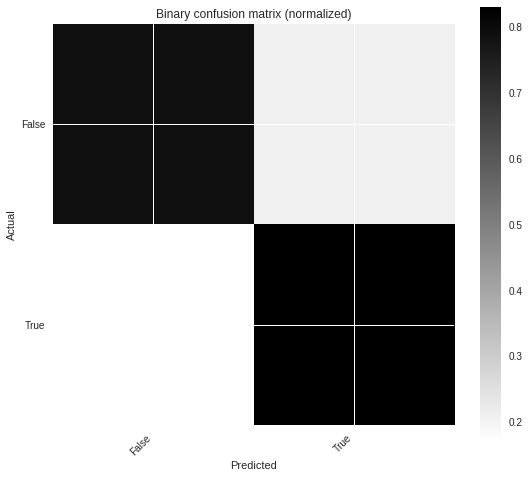

In [50]:
import matplotlib.pyplot as plt

cm.plot(normalized=True)
plt.show